# Desmistificando la transformada de ondeletas

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Febrero 2021 · 7 min read

---

## Resumen

En este ipython notebook estudiamos la transformada de ondeletas (o _wavelets_ como se conoce en inglés). La misma es un tema interesante de estudiar porque constituye una alternativa a la transformada de Fourier de corto plazo (STFT, por sus siglas en Inglés) al atenuar el problema del principio de incertidumbre de Heinserberg, que dicta que a mayor resolución frecuencial menor resolución temporal, y viceversa. En la literatura es posible encontrar tanto la transformada de ondeletas continua (CWT, por sus siglas en Inglés), como su versión discreta o _discrete time wavelet transform_ (DTWT), y el banco de filtros asociado a un fenómeno llamado distribución diádica. Además, es posible encontrar librerías que implementan la DTWT para el análisis de frecuencias. Aunque este notebook no tiene componentes originales, explicamos la teoría básica de los wavelets y varios ejemplo de aplicación.

# Definición de ondeleta

Una ondeleta se define como una señal de energía finita y corta duración, que debe cumplir dos condiciones: tener media cero y cumplir el principio de admisibilidad. La primer condición se puede expresar como sigue [2]:

$$
\int_{-\infty}^{\infty}{\psi(t)dt} = 0,
$$

y la segunda, consiste en tener energia finita a lo largo del tiempo (a diferencia de los senoidales usados en la transformada de Fourier):

$$
C_{\psi} = \int_{-\infty}^{\infty}{\frac{|\Psi(\omega)|^2}{|\omega|}d\omega} < \infty,
$$

donde $\Psi(\omega)=\mathscr{F}\{\psi(t)\}(f)$, $\mathscr{F}\{\cdot\}(f)$ es la transformada de Fourier, $\omega=2\pi f$ es la frecuencia expresada en radianes por segundo y $f \in \mathbb{R}$ es la frecuencia en hercios. Un ejemplo de una ondeleta es la función Ricker u _ondeleta sombrero_, que se define como sigue [1]:

$$
\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{1/4}} \left({1-{\left({\frac{t}{\sigma}}\right)}^2}\right) e^{-\frac{t^2}{2\sigma^2}},
$$

donde $\sigma \in \mathbb{R}$ controlar la amplitud del lóbulo principal y $t \in \mathbb{R}$ representa el tiempo continuo. Gráficamente, la ecuación anterior dibuja la siguiente curva:

Populating the interactive namespace from numpy and matplotlib


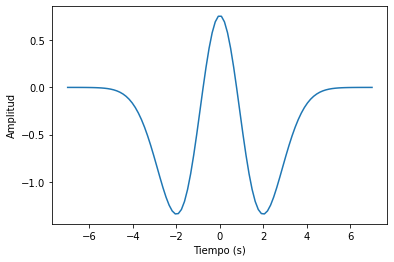

In [5]:
%pylab inline
from scipy import signal
import numpy as np

def sombrero(x,sigma=1.3):
    return (2/(np.sqrt(3*sigma)*np.pi**0.25)) * (1-(x*sigma)**2) * (np.exp(-(x**2)/(2*sigma**2)))

t = np.linspace(-7,7,100)
plt.plot(t,sombrero(t))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

A partir de una función como esta (llamada _ondeleta madre_) se pueden derivar otras ondeletas de la misma forma pero que varían en términos de escalamientos y desplazamientos (definidos según los parámetros $a$ y $b$, respectivamente):

$$
\psi_{a,b}(t) = \frac{1}{\sqrt{a}}\,\psi\left(\frac{t-b}{a}\right).
$$

Por ejemplo, para la ondeleta del sombrero, hacemos un escalamiento por $0.5$ s y un desplazamiento por $4$ s, y obtenemos la siguiente curva:

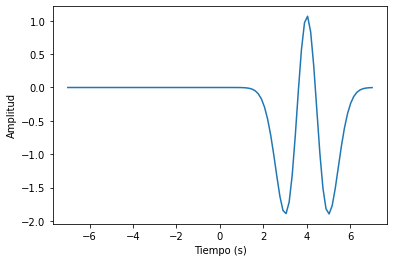

In [6]:
def ondeletaMadre(t,a,b,ondeletaFunc):
    return ondeletaFunc((t-b)/a) * 1.0/np.sqrt(a)

plt.plot(t,ondeletaMadre(t,a=0.5,b=4,ondeletaFunc=sombrero)) # retrasar 2 segundos y cambiar ancho a la mitad
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

Otro ejemplo de una ondeleta es la ondeleta Haar, propuesta en 1909 por el matemático húngaro Alfréd Haar, que define una función cuyo soporte es $-1$ en el rango $[0,0.5]$, $1$ en el rango $[0.5,1]$ y cero en el resto [5]. Este wavelet tiene una buena resolución temporal, y por ello es usado para tareas de deteción de bordes en imágenes [6].

# Transformada continua de ondeleta

La ondeleta madre permite definir otro concepto llamado _transformada de ondeleta continua_ (CWT, por sus siglas en inglés) que permite obtener coeficientes de análisis con esta ecuación [2]:

$$
\text{CWT}_f(a,b) = \int_{-\infty}^{\infty}{x(t)\,\psi^{*}_{a,b}(t)dt},  
$$

siendo el operador $\cdot^{*}$, el conjugado complejo (definido como $(a+bi)^{*}=a-bi$). Al igual que pasa con la transformada de Fourier, esta ecuación no es otra cosa que la correlación entre la función ondeleta (escalada y trasladada por $a$ y $b$) y la función $x$. 

Un ejemplo de implementación de esta ecuación puede verse abajo:

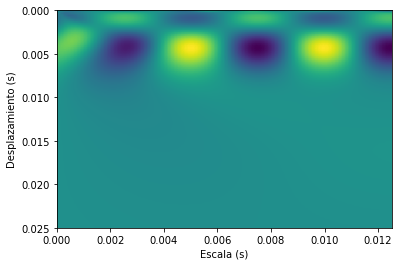

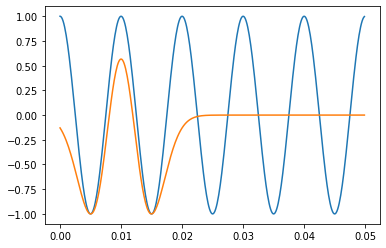

In [7]:
def CWT(f,a,b,ondeleta=sombrero):
    return np.dot(ondeletaMadre(np.arange(0,len(f)),a,b,ondeleta), f)

F0 = 100 # frec. fundamental (Hz)
Fs = 8e3 # frec. muestreo (Hz)
N = int(5*Fs/F0) # mostrar 5 periodos de la senal

n = np.arange(0,N)
y = np.cos(2*np.pi*F0/Fs*n) # f=F0/Fs: frecuencia discreta

A = np.linspace(0.1,100,100)
B = np.linspace(0.1,200,100)
F = np.zeros([len(A),len(B)])
for iA in range(0,len(A)):
    for iB in range(0,len(B)):
        F[iA,iB]=CWT(y,A[iA],B[iB])
       
figure()
plt.imshow(F, aspect='auto', extent=[0, A[-1]/Fs, B[-1]/Fs,0]) 
plt.ylabel('Desplazamiento (s)')
plt.xlabel('Escala (s)')
show()

figure()
t=n/Fs
plt.plot(t,y)
w = ondeletaMadre(t,a=0.0025,b=2*0.005,ondeletaFunc=sombrero)
plt.plot(t,w/max(abs(w)))
show()

Acá se observa que en en punto $b=0.01$ hay en efecto un pico de energía.

# Transformada discreta de ondeletas

La transformada de ondeletas, al igual que la transformada de Fourier, tiene una versión discreta definida como sigue [3,4]:

$$
\text{DTWT}_f[a,b] = \frac{1}{\sqrt{b}} \sum_{m=0}^{p-1}{x[t_m] \, \psi\big[\frac{t_m-a}{b}\big]},  
$$

donde:
* $t_m = t(mT_s)$,
* $T_s$ es el periodo de muestreo (en segundos),
* $a=K2^{-j}$,
* $b=2^{-j}$,
* $j \in \mathbb{N}$ es el índice de escalamiento,
* $K \in \mathbb{N}$ es el índice de la ondeleta.

Como $a$ y $b$ son potencias de dos, se dice que la transformada DTWT es diádica; esto además define un banco de filtros que se traslapan de la siguiente forma:

<img src="img/bancoFiltros.jpg" width="40%"></img>

(1.000000,1.000000)
(0.500000,0.500000)
(0.250000,0.250000)
(0.125000,0.125000)
(0.062500,0.062500)


<Figure size 432x288 with 0 Axes>

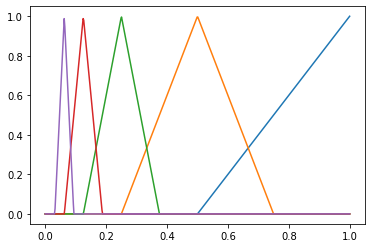

(2.000000,1.000000)
(1.000000,0.500000)
(0.500000,0.250000)
(0.250000,0.125000)
(0.125000,0.062500)


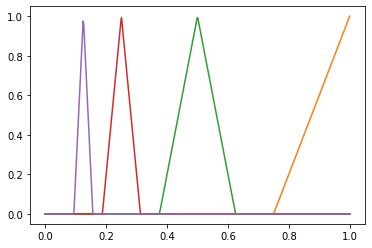

In [29]:
def triangulo(x):
    return 1-np.abs(2*x) if np.abs(x)<=0.5 else 0

plt.figure()
time = np.linspace(0,1,500)

for k in range(1,3):
    plt.figure()
    for j in range(0,5):
        b = 2**(-j)
        a = k*b
        print('(%2f,%2f)' % (a,b))
        plt.plot(time,[triangulo((t-a)/b) for t in time])
    plt.show() 

A nivel computacional, este análisis puede optimizarse de la siguiente manera [6]:

<img src="img/bancoFiltros2.jpg" width="60%"></img>

es decir, que la porción de la señal filtrada por el filtro pasa-bajas define un coeficiente, mientras que la porción filtrada por el filtro pasa-altas define multiples coeficientes por un filtrado iterativo. En la imagen anterior, $L$ al filtro pasa-bajas, $H$ representa el filtro pasa-altas (obtenido de $L$ por la técnica de [espejo en cuadratura](https://es.wikipedia.org/wiki/Filtro_espejo_en_cuadratura)), $H_{\text{up}}$ y $L_{\text{up}}$ son filtros adicionales pasa-altas y pasa-bajas con decimación, y $cD^*$ y $cA^*$ son los coeficientes de la transformada. La parte derecha del gráfico es una etapa de síntesis que no nos interesa tanto explicar en este ipython notebook [6]. 

Este análisis por el banco de filtros está relacionado con la [propiedad de multiresolución](https://en.wikipedia.org/wiki/Multiresolution_analysis), que constituye el atractivo de la transformada de ondeletas, pues aplicando una ventana de análisis más larga para frecuencia bajas, y más corta para frecuencias altas, se logra atenuar el problema del principio de Incertidumbre de Heisenberg. Recordemos en la STFT las ventanas de análisis son fijas, y por lo tanto a mayor resolución temporal, menor resolución frecuencial y viceversa [6].

<img src="img/multiresolution.jpg" width="50%"></img>

# Empleando librerias existentes

La CWT y la DTWT pueden encontrarse implementadas en Python dentro de las librerías Scipy (`signal.CWT`) y Obspy (`obspy.signal.tf_misfit.CWT`). Abajo se proponen dos ejemplos para calcular el espectrograma.

**Signal.CWT:**

(63, 44100)


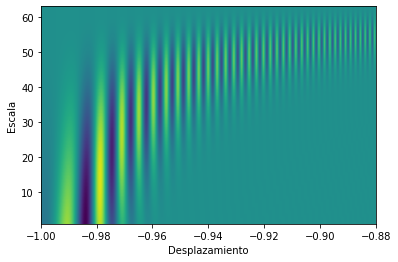

In [31]:
from IPython.display import Audio

# construimos un barrido de frecuencias
rango = [20, 20e3] # el rango promedio de audicion humano en Hz
Fs = 44.1 * 1e3 # la tasa de muestreo de los equipos comerciales
T = 1.0 # segundos (t1-t0)
N = int(T*Fs) # s . 1/s
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]

y = np.sin(2*np.pi*F0/(2*Fs)*n) # f=F0/Fs: frecuencia discreta

# aplicamos la CWT
widths = np.arange(1, 64)
cwtmatr = signal.cwt(y, wavelet=signal.ricker, widths=widths)

print(cwtmatr.shape)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 63], aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.xlim([-1,-0.88])
plt.xlabel('Desplazamiento')
plt.ylabel('Escala')
plt.show()

Audio(y, rate=Fs) 

**obspy.signal.tf_misfit.CWT:**

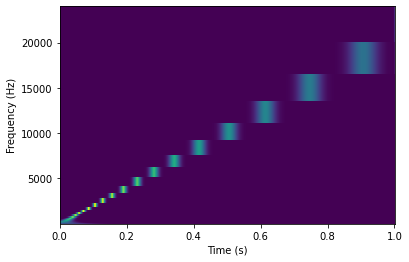

In [32]:
import obspy # pip3 install obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

scalogram = cwt(st=y, dt=1.0/Fs, w0=32, fmin=0.0001, fmax=Fs/2) # morlet

ax = plt.figure().add_subplot(111)
t = np.linspace(0,T,N)
x_axis, y_axis = np.meshgrid(t,np.logspace(np.log10(0.0001), np.log10(Fs/2), scalogram.shape[0]))
ax.pcolormesh(x_axis, y_axis, np.abs(scalogram), cmap=obspy_sequential, shading='auto')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.show()

# Conclusiones
Una ondeleta es una función de corta duración que cumple dos condiciones: tener media cero y cumplir el principio de admisibilidad (tener energía finita a lo largo del tiempo). Dos ejemplos de ondeletas son la función Ricker (o sombrero mexicano) y la ondeleta de Haar. Cuando sufre escalamiento y traslaciones, la ondeleta descrita en la función se llama ondeleta madre. Existen dos tipos de transformada de ondeletas, la transformada continua (CWT) y la transformada discreta (DTWT), ambas son correlaciones de la función de entrada con un banco de filtros formados por las ondeletas escaladas y trasladadas. Esta correlación da lugar a un concepto llamado escalograma, que a diferencia del espectrograma, goza del principio de multiresolución para mitigar el principio de incertidumbre de Heisenber. En el caso de la DTWT, el banco de filtros sigue una distribución diádica (en potencias de dos), y a nivel computacional los filtros están dispuestos en forma de cascada (la porción de la señal filtrada por el filtro pasabajas es descompuesta recursivamente). Python ofrece dos formas de calcular la CWT a través de las librerías `signal.CWT` y `obspy.signal.tf_misfit.CWT`.

# Referencias

1. Wikipedia contributors. (2021, February 17). Mexican hat wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 00:05, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Mexican_hat_wavelet&oldid=1007284050

2. M. Vetterli, J. Kovacevic. Wavelets and Subband Coding. Orignally published in 1995 by Prentice Hall PTR, Englewood Cliffs, New Jersey. Reissued by authors in 2007.

3. Wikipedia contributors. (2021, March 3). Correlation and dependence. In Wikipedia, The Free Encyclopedia. Retrieved 00:47, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Correlation_and_dependence&oldid=1010073167

4. Andrew Nicoll. The Wavelet Transform for Beginners. URL: https://youtu.be/kuuUaqAjeoA (consultado por última vez el 05/22/21)

5. Wikipedia contributors. (2021, March 25). Haar wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 03:43, May 27, 2021, from https://en.wikipedia.org/w/index.php?title=Haar_wavelet&oldid=1014128738\

6. D. Lee Fugal. Conceptual Wavelets, in digital signal processing. Space and signals technical publishing. 2009. ISBN 978-0-9821994-5-9.

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2021,
  author = {Juan M. Fonseca-Solís},
  title = {Desmistificando la transformada de ondeletas},
  year = 2021,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.wavelets.html},
  urldate = {}
}
```